In [2]:
import pubchempy as pcp
import pandas as pd
import re
from tqdm import tqdm
from utils import *
from kg_gen_4 import *
from matplotlib_venn import venn2,venn2_circles, venn2_unweighted

In [4]:
#importing PD map file provided by LSCB
 
df = pd.read_csv('../data/misc//PD_map.csv')

#importing drugs file from KGG
pd_drugs = pd.read_csv('../data/kgs/ndd/pd/diseaseAssociatedDrugs.csv')

#import protein files from KKG

pd_prots = pd.read_csv('../data/kgs/ndd/pd/diseaseAssociatedProteins.csv')

#load PD KG 
infile = open('../data/kgs/ndd/pd/pd_dec24.pkl','rb')
query_graph = pickle.load(infile)
infile.close()

In [27]:
pd_prots.head()

Unnamed: 0 Protein        ENSG       UniProt       Source        Score   disease_id  
0       0        LRRK2  ENSG00000188906  Q5S007  uniprot_swissprot  0.881  MONDO_0005180
1       1         PRKN  ENSG00000185345  O60260  uniprot_swissprot  0.858  MONDO_0005180
2       2      ATP13A2  ENSG00000159363  Q9NQ11  uniprot_swissprot  0.850  MONDO_0005180
3       3        PINK1  ENSG00000158828  Q9BXM7  uniprot_swissprot  0.847  MONDO_0005180
4       4         SNCA  ENSG00000145335  P37840  uniprot_swissprot  0.841  MONDO_0005180

In [4]:
df.head(5)

id                  name                type    class   HGNC_SYMBOL UNIPROT CHEBI  PUBCHEM PUBCHEM_SUBSTANCE  GO  REACTOME   PUBMED  
0  634264.0      LGE-derived GABAergic cell  Complex  element      NaN       NaN    NaN   NaN            NaN        NaN    NaN    2.703e+07
1  634281.0   POa-derived cell NR2F2+ NRP2+  Complex  element      NaN       NaN    NaN   NaN            NaN        NaN    NaN    2.631e+07
2  634187.0   POa-derived cell NR2F2- NRP2-  Complex  element      NaN       NaN    NaN   NaN            NaN        NaN    NaN    2.249e+07
3  634289.0   POa-derived cell NR2F2- NRP2-  Complex  element      NaN       NaN    NaN   NaN            NaN        NaN    NaN    2.249e+07
4  630511.0                          14-3-3  Complex  element      NaN       NaN    NaN   NaN            NaN        NaN    NaN          NaN

# Identify shared drugs

In [5]:
#Filter out drugs
drug = df.loc[df['type'].str.contains('Drug',na=False)]
drug = drug.reset_index(drop=True)

In [6]:
drug.head()

id              name            type  class   HGNC_SYMBOL UNIPROT    CHEBI       PUBCHEM PUBCHEM_SUBSTANCE  GO  REACTOME  PUBMED
0  631341.0          3-methyladenine  Drug  element      NaN       NaN   CHEBI:38635       NaN         NaN        NaN    NaN     NaN  
1  635692.0  A2A receptor antagonist  Drug  element      NaN       NaN   CHEBI:53121       NaN         NaN        NaN    NaN     NaN  
2  635549.0                   AQW051  Drug  element      NaN       NaN           NaN       NaN         NaN        NaN    NaN     NaN  
3  626856.0           Angiotensin II  Drug  element      NaN       NaN           NaN  172198.0         NaN        NaN    NaN     NaN  
4  631843.0                    BAPTA  Drug  element      NaN       NaN   CHEBI:60888       NaN         NaN        NaN    NaN     NaN

In [8]:
#convert drug names to chembl identifier 
#method 1: try to see if it matches with preferred names in ChEMBL database

from chembl_webresource_client.new_client import new_client #Import ChEMBL python client

molecule = new_client.molecule

pd_map_drugs = []
for item in tqdm(list(set(drug['name']))):
    #print(item)
    mols = molecule.filter(pref_name__iexact=item).only('molecule_chembl_id')
    if mols:
        #print(mols)
        for chem in mols:
            #print(chem['molecule_chembl_id'])
            pd_map_drugs.append(chem['molecule_chembl_id'])
            
print('Total drugs: ',len(pd_map_drugs))

  0%|          | 0/42 [00:00<?, ?it/s]

Total drugs:  29


In [15]:
#convert drug names to chembl identifier 
#method 2: try to see if it matches with one of the synonyms in ChEMBL database

from chembl_webresource_client.new_client import new_client #Import ChEMBL python client

molecule = new_client.molecule

pd_map_drugs = []
for item in tqdm(list(set(drug['name']))):
    #print(item)
    mols = molecule.filter(molecule_synonyms__molecule_synonym__iexact=item).only('molecule_chembl_id')
    if mols:
        #print(mols)
        for chem in mols:
            #print(chem['molecule_chembl_id'])
            pd_map_drugs.append(chem['molecule_chembl_id'])
            
print('Total drugs: ',len(pd_map_drugs))

  0%|          | 0/42 [00:00<?, ?it/s]

Total drugs:  32


In [18]:
pd_drugs = list(set(pd_drugs['drugId']))
print('Total drugs: ',len(pd_drugs))

Total drugs:  169


In [19]:
shared_chem = [x for x in pd_drugs if x in pd_drugs]
len(shared_chem)

169

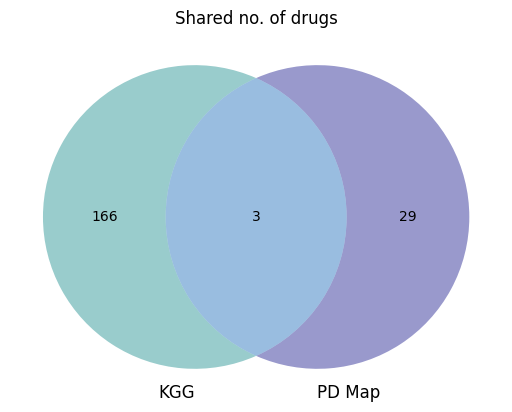

In [20]:
#Get venn diagram for shared no. of drugs

set1= set(pd_drugs)
set2= set(pd_map_drugs)

venn2_unweighted([set1,set2], set_colors=('teal', 'navy'), set_labels = ('KGG','PD Map'))
plt.title("Shared no. of drugs")
plt.savefig('../data/kgs/ndd/pd/shared_drugs.png',dpi = 500)
plt.show()

# Identify shared proteins

In [21]:
#Filter out proteins for PD map file
prtn = df.loc[df['type'].isin(['Protein','RNA','Gene'])]

In [22]:
#remove instances of NA values
prtn = prtn[prtn['UNIPROT'].notna()]

In [23]:
prtn = prtn.drop_duplicates(subset=['HGNC_SYMBOL','UNIPROT'], keep='first')

In [24]:
prtn = prtn.reset_index(drop=True)

In [25]:
prtn.head()

id     name   type  class   HGNC_SYMBOL UNIPROT CHEBI  PUBCHEM PUBCHEM_SUBSTANCE  GO  REACTOME  PUBMED
0  627069.0   GDNF  Gene  element      GDNF    P39905   NaN   NaN            NaN        NaN    NaN     NaN  
1  634635.0  NR2F1  Gene  element     NR2F1    P10589   NaN   NaN            NaN        NaN    NaN     NaN  
2  634412.0  NR2F2  Gene  element     NR2F2    P24468   NaN   NaN            NaN        NaN    NaN     NaN  
3  634311.0   NRP1  Gene  element      NRP1    O14786   NaN   NaN            NaN        NaN    NaN     NaN  
4  634314.0   NRP2  Gene  element      NRP2    O60462   NaN   NaN            NaN        NaN    NaN     NaN

In [28]:
pd_prots = list(set(pd_prots['UniProt']))

['P47989',
 'O75390',
 'P05388',
 'Q8N961',
 'Q5J8M3',
 'Q6PHR2',
 'P12755',
 'O95678',
 'Q9BTU6',
 'Q7Z739',
 'Q9Y490',
 'Q13228',
 'Q12948',
 'P08034',
 'O75362',
 'Q8WYK1',
 'P00480',
 'P12318',
 'P51808',
 'Q14738',
 'Q05586',
 'Q9BQS7',
 'P28702',
 'P08758',
 'P08700',
 'O14842',
 'Q92876',
 'Q8TF47',
 'P33076',
 'P12524',
 'Q6V0I7',
 'Q9Y458',
 'P34130',
 'P20941',
 'Q6ZT07',
 'Q96AP4',
 'Q8IX15',
 'Q03405',
 'Q86YR5',
 'Q969M1',
 'Q9NR48',
 'Q9Y2T6',
 'Q86WZ6',
 'Q9Y6A2',
 'P08603',
 'Q96RL7',
 'Q7Z624',
 'Q12778',
 'Q92574',
 'Q9GZU7',
 'P04004',
 'P17693',
 'Q8TF61',
 'Q6XE24',
 'P23582',
 'Q8IV63',
 'P52732',
 'O14514',
 'Q16881',
 'Q8N183',
 'P20382',
 'P49760',
 'P49418',
 'O75146',
 'P24821',
 'Q14168',
 'Q9H2B4',
 'O95486',
 'P42684',
 'P05120',
 'Q9H0E2',
 'Q9Y4F5',
 'P13500',
 'Q9GZT9',
 'P05113',
 'P49366',
 'Q13464',
 'P67870',
 'O43752',
 'Q9BSA4',
 'O43731',
 'Q13772',
 'Q9H8Y5',
 'Q9NPD7',
 'Q16288',
 'P30153',
 'Q8N9W4',
 'Q15257',
 'Q9BXS6',
 'P57735',
 'O00142',

In [29]:
shared_prots = [x for x in prtn['UNIPROT'] if x in pd_prots]
len(shared_prots)

654

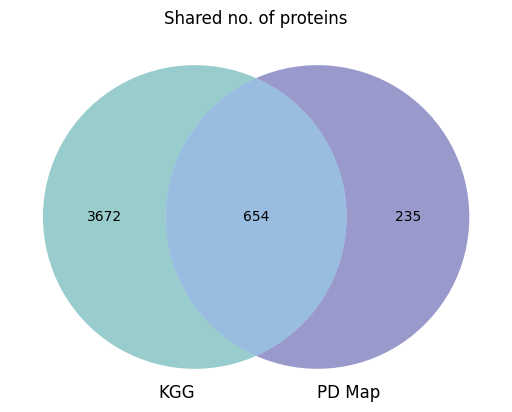

In [32]:
#Get venn diagram for shared no. of drugs

set1= set(pd_prots)
set2= set(prtn['UNIPROT'] )

venn2_unweighted([set1,set2], set_colors=('teal', 'navy'), set_labels = ('KGG','PD Map'))
plt.title("Shared no. of proteins")
plt.savefig('../data/kgs/ndd/pd/shared_proteins.png',dpi = 500)
plt.show()

# Identify shared biological processes

In [33]:
bp = df.loc[df['type'].isin(['Phenotype'])]

In [34]:
bp = bp[bp['GO'].notna()]

In [35]:
bp = bp.drop_duplicates(subset=['GO'], keep='first')

In [36]:
bp = bp.reset_index(drop=True)

In [38]:
bp.head()

id                      name                     type     class   HGNC_SYMBOL UNIPROT CHEBI  PUBCHEM PUBCHEM_SUBSTANCE      GO     REACTOME  PUBMED
0  635448.0                Wnt/Î²-catenin signaling  Phenotype  element      NaN       NaN    NaN   NaN            NaN        GO:0060070    NaN     NaN  
1  627727.0  3-hydroxyacyl-CoA dehydratase activity  Phenotype  element      NaN       NaN    NaN   NaN            NaN        GO:0018812    NaN     NaN  
2  634052.0                             ACh release  Phenotype  element      NaN       NaN    NaN   NaN            NaN        GO:0014055    NaN     NaN  
3  635434.0                             AKT pathway  Phenotype  element      NaN       NaN    NaN   NaN            NaN        GO:0043491    NaN     NaN  
4  630501.0                    AMPK kinase activity  Phenotype  element      NaN       NaN    NaN   NaN            NaN        GO:0004679    NaN     NaN

In [5]:
#read prot dict created by the KGG
#using GOBP ids for mapping #Reason: Names from PD map have utf-8 issues
infile = open('../data/kgs/ndd/pd/pd_dec24_prot_dict.pkl','rb')
prot_dict = pickle.load(infile)
infile.close()

In [6]:
len(prot_dict)

4326

In [39]:
def getGOids(protDict):
    
    temp_fn = []
    temp_bp = []
    
    for prot in protDict:
    
        fn = list(protDict[prot]['Function'].values())
        
        for f in fn: 
            if f not in temp_fn:
                temp_fn.append(f)
                
        bp = list(protDict[prot]['BioProcess'].values())
        
        for b in bp: 
            if b not in temp_bp:
                temp_bp.append(b)
                
    return(temp_fn,temp_bp)
        
        

In [45]:
id_list = getGOids(prot_dict)

In [46]:
gofn, gobp = id_list[0] ,id_list[1]

In [47]:
shared_bp = [x for x in bp['GO'] if x in gobp]
len(shared_bp)

188

In [48]:
shared_fn = [x for x in bp['GO'] if x in gofn]
len(shared_fn)

23

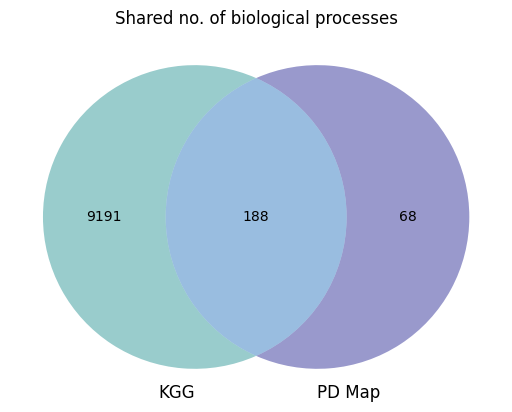

In [50]:
#Get venn diagram for shared no. of drugs

set1= set(gobp)
set2= set(bp['GO'] )

venn2_unweighted([set1,set2], set_colors=('teal', 'navy'), set_labels = ('KGG','PD Map'))
plt.title("Shared no. of biological processes")
plt.savefig('../data/kgs/ndd/pd/shared_bp.png',dpi = 500)
plt.show()


# PD drugs profiles

In [8]:
chembl = pd.read_csv('../data/kgs/ndd/pd/diseaseAssociatedDrugs.csv',index_col=0)

In [25]:
chembl.head()

approvedSymbol                    approvedName                             prefName              drugType        drugId      phase              ctIds                    id            disease      
0       DRD4                                   dopamine receptor D4  APOMORPHINE HYDROCHLORIDE  Small molecule  CHEMBL5314363   4.0                               []  MONDO_0005180  Parkinson disease
1     GRIN2A      glutamate ionotropic receptor NMDA type subuni...               ORPHENADRINE  Small molecule      CHEMBL900   4.0                               []  MONDO_0005180  Parkinson disease
2      CHRM3                      cholinergic receptor muscarinic 3                   ATROPINE  Small molecule   CHEMBL517712   4.0                               []  MONDO_0005180  Parkinson disease
3      GRIN1      glutamate ionotropic receptor NMDA type subunit 1                  MEMANTINE  Small molecule      CHEMBL807   4.0   ['NCT00646204', 'NCT01108029']  MONDO_0005180  Parkinson disease
4     GRIN2D      glutamate ionotropic receptor NMDA type subuni...                 AMANTADINE  Small molecule      CHEMBL660   4.0                               []  MONDO_0005180  Parkinson disease

In [27]:
len(set(chembl['drugId']))

169

In [28]:
calc_filters = calculate_filters(chembl,'drugId')

Getting SMILES for CHEMBL ids and generating descriptors:   0%|          | 0/169 [00:00<?, ?it/s]

This ChEMBL id could not be parsed: CHEMBL1201567
This ChEMBL id could not be parsed: CHEMBL4650495
This ChEMBL id could not be parsed: CHEMBL1201631
This ChEMBL id could not be parsed: CHEMBL2109092
This ChEMBL id could not be parsed: CHEMBL1201670
This ChEMBL id could not be parsed: CHEMBL1201574
This ChEMBL id could not be parsed: CHEMBL4298077
This ChEMBL id could not be parsed: CHEMBL2108380
This ChEMBL id could not be parsed: CHEMBL2108724
This ChEMBL id could not be parsed: CHEMBL2108336
This ChEMBL id could not be parsed: CHEMBL2108035
This ChEMBL id could not be parsed: CHEMBL3833330
This ChEMBL id could not be parsed: CHEMBL1201649
Reason: Drug has no SMILES representation because its type is either antibody, protein or unknown


In [29]:
calc_filters

drugId                           smiles                        Violation(s)_ro5  Lipinski_ro5    MW     HBA  HBD  LogP   Ghose  AtomNum  MolRefractivity  Veber  RotBond   TPSA   REOS  Charge  HeavyAtom  QED  RingNum  phase
0    CHEMBL1200604                   CCN(Cc1ccncc1)C(=O)C(CO)c1ccccc1          0               0       284.359   4    1   2.206    0      21          81.597        0       6      53.43    0      0       21       1      2       2  
1      CHEMBL75133  CC(/C=C/[C@@H]1C[C@]1(C)c1ccc2c(c1)C(C)(C)CCC2...          1               0       352.518   2    1   5.900    1      26         107.720        0       4      37.30    1      0       26       1      3       1  
2     CHEMBL419792                 CN[C@@H]1Cc2cccc3[nH]c(=O)n(c23)C1          0               0       203.245   4    2   0.474    1      15          59.110        0       1      49.82    0      0       15       0      3       3  
3    CHEMBL2218896   CCCCCCC(C)(C)c1cc(O)c2c(c1)OC(C)(C)C1CCC(=O)CC21          1               0       372.549   3    1   6.264    1      27         109.688        0       6      46.53    1      0       27       1      3       3  
4       CHEMBL1324       Cc1ccc(C(=O)c2cc(O)c(O)c([N+](=O)[O-])c2)cc1          0               0       273.244   6    2   2.545    0      20          71.038        0       3     100.67    0      0       20       0      2       4  
..             ...                                                ...               ...           ...      ...  ...  ...    ...    ...      ...              ...    ...      ...     ...   ...     ...        ...  ...      ...    ...
151      CHEMBL655             Cc1ncc2n1-c1ccc(Cl)cc1C(c1ccccc1F)=NC2          0               0       325.774   3    0   4.324    0      23          89.054        0       1      30.18    0      0       23       0      4       1  
152     CHEMBL1115                          CN(C)C(=O)Oc1ccc[n+](C)c1          0               0       181.215   4    0   0.571    1      13          47.329        0       1      33.42    1      1       13       0      1       2  
153      CHEMBL636                CCN(C)C(=O)Oc1cccc([C@H](C)N(C)C)c1          0               0       250.342   4    0   2.760    1      18          72.872        0       4      32.78    0      0       18       0      1       4  
154  CHEMBL1255582                     CCC1(c2c[nH]cn2)Cc2ccc(F)cc2C1          0               0       230.286   2    1   2.995    1      17          64.365        0       2      28.68    0      0       17       0      3       2  
155      CHEMBL112                                 CC(=O)Nc1ccc(O)cc1          0               0       151.165   3    2   1.351    1      11          42.411        0       1      49.33    1      0       11       0      1       1  

[156 rows x 20 columns]

In [30]:
filter_cols = ['Lipinski_ro5',
 'Ghose',
 'Veber',
 'REOS',
 'QED']

df_filters = calc_filters[filter_cols]

df = df_filters
df2 = df.stack().groupby(level=[1]).value_counts().unstack()
# Preferred order of stacked bar elements
stack_order = [0, 1]
df2 = df2[stack_order]

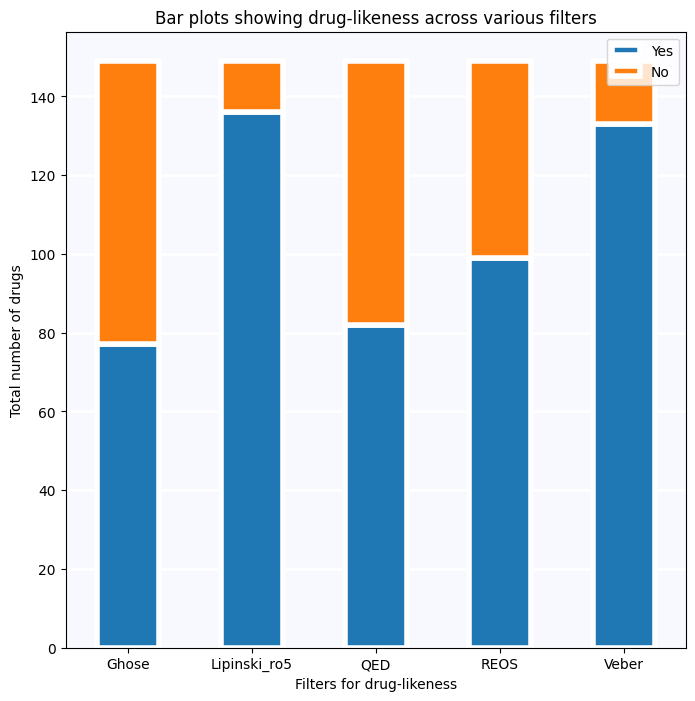

In [8]:
xx = df2.plot.bar(rot=0, stacked=True,
                  figsize = [8,8],
                  title='Bar plots showing drug-likeness across various filters',
                  xlabel = 'Filters for drug-likeness',
                  ylabel = 'Total number of drugs',
                  #table = df2,
                  linewidth = 4,
                  edgecolor='white', 
                  #grid = 2

                 )

#plt.style.use('default')
xx.set_facecolor("ghostwhite")
#%matplotlib inline

xx.set_axisbelow(True)
xx.yaxis.grid(color='white', linewidth = 2)
#_ = xx.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
xx.legend(['Yes', "No"])
#xx.axis('on')
# plt.subplots_adjust(top=2)
# plt.tight_layout()
# plt.subplots_adjust(bottom=0.5)

In [26]:
xx.get_figure().savefig('../data/kgs/ndd/pd/druglikeness.png', format='png', dpi = 1000)

In [31]:
calc_filters['Flag'] = df_filters.sum(axis=1, numeric_only=True)

In [32]:
#rearrange cols

recol = list(calc_filters.columns)
recol = ['drugId',
 'smiles',
 'MW',
 'HBA',
 'HBD',
 'LogP',
 'AtomNum',
 'MolRefractivity',
 'RotBond',
 'TPSA',
 'Charge',
 'HeavyAtom',
 'RingNum','Violation(s)_ro5','Lipinski_ro5','Ghose','Veber','REOS','QED',
 'phase',
 'Flag']

In [33]:
calc_filters = calc_filters[recol]
calc_filters.to_csv('../data/kgs/ndd/pd/druglikeness.csv',index=0)

In [34]:
calc_filters.groupby('Flag').size()

Flag
0    46
1    50
2    28
3    15
4     8
5     9
dtype: int64

In [35]:
for item in filter_cols:
    print(calc_filters.groupby(item).size(),'\n')

Lipinski_ro5
0    142
1     14
dtype: int64 

Ghose
0    81
1    75
dtype: int64 

Veber
0    139
1     17
dtype: int64 

REOS
0    105
1     51
dtype: int64 

QED
0    85
1    71
dtype: int64 



In [40]:
passAll = calc_filters.loc[calc_filters['Flag'] == 0]

In [44]:
len(passAll)

46

In [37]:
passAll.groupby('phase').size()

phase
1     6
2    19
3     9
4    12
dtype: int64

In [45]:
failAll = calc_filters.loc[calc_filters['Flag'] == 5]

In [39]:
failAll.groupby('phase').size()

phase
1    1
2    3
3    1
4    4
dtype: int64

In [46]:
len(failAll)

9